In [7]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2

cv2.__version__
 
from google.colab import drive
drive.mount("/content/gdrive/")
path = "/content/gdrive/My Drive/Chap11/"

min_confidence=0.2

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
file = path + "images/TravelandTransport_NEanywhere_199.jpg"
# load the input image and grab the image dimensions
image = cv2.imread(file)
orig = image.copy()
(H, W) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [0]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [13]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(path + 'frozen_east_text_detection.pb')
 
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
 
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.434279 seconds


In [0]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
  # loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < min_confidence:
			continue
 
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
 
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
 
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
 
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

[[ 61 122 116 146]
 [116 126 179 149]
 [  9 118  58 149]]


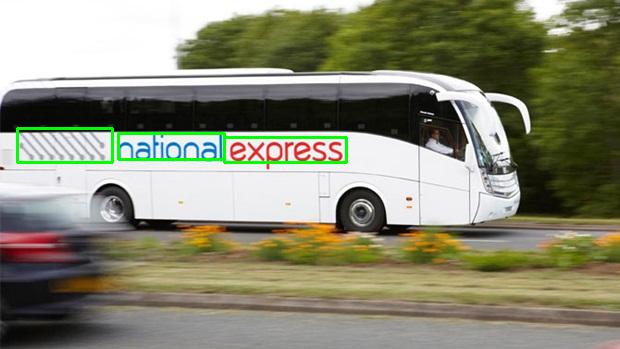

In [16]:
 from google.colab.patches import cv2_imshow

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
print(boxes)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
 
	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
 
# show the output image
cv2_imshow(orig)